# **Problem Statement**
The project aims to develop an intelligent driver
drowsiness detection system using deep learning techniques. By
analyzing real-time video data, the system identifies signs of
drowsiness or fatigue in drivers, such as eye closure, head
nodding, or changes in facial expressions. Utilizing convolutional
neural networks (CNNs) and recurrent neural networks (RNNs),
the model detects these patterns and provides timely alerts to the
driver. The Driver Drowsiness Dataset (DDD) was employed for
training and testing, leading to a solution that can potentially
mitigate the significant risk of accidents caused by drowsy
driving

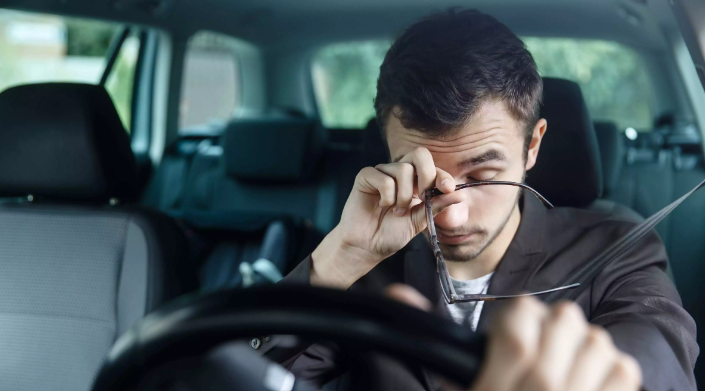

In [1]:
from IPython.display import Image, display

image_path = '/content/drive/MyDrive/Driver Drowsiness Dataset (DDD)/DDD.png'

# Display the image
display(Image(image_path))


# **Pre-Processing**

### Import all dependencies

In [2]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import time
from tensorflow.keras.layers import Input,Dense,Conv2D,Conv3D,DepthwiseConv2D,SeparableConv2D,Conv3DTranspose
from tensorflow.keras.layers import Flatten,MaxPool2D,AvgPool2D,GlobalAvgPool2D,UpSampling2D,BatchNormalization
from tensorflow.keras.layers import Concatenate,Add,Dropout,ReLU,Lambda,Activation,LeakyReLU,PReLU
import tensorflow.keras.backend as K
from IPython.display import SVG
from tensorflow.keras.preprocessing import image
from time import time

### Define Few Parameters

In [3]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
drowsy_path = '/content/drive/MyDrive/Driver Drowsiness Dataset (DDD)/Drowsy 1'
nondrowsy_path = '/content/drive/MyDrive/Driver Drowsiness Dataset (DDD)/Non Drowsy 2'

# Use glob to grab images from path .jpg or jpeg
drowsy_files = glob(drowsy_path + '/*')
nondrowsy_files = glob(nondrowsy_path + '/*')

### Fetch Images and Class Labels from Files (This might take a while)

In [4]:
# Preparing Labels
drowsy_labels = []
nondrowsy_labels = []

drowsy_images=[]
nondrowsy_images=[]

import cv2

for i in range(len(drowsy_files)):
  image = cv2.imread(drowsy_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  drowsy_images.append(image)
  drowsy_labels.append('drowsy')
for i in range(len(nondrowsy_files)):
  image = cv2.imread(nondrowsy_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  nondrowsy_images.append(image)
  nondrowsy_labels.append('Nondrowsy')

### Visualize First 40 Images from Data set

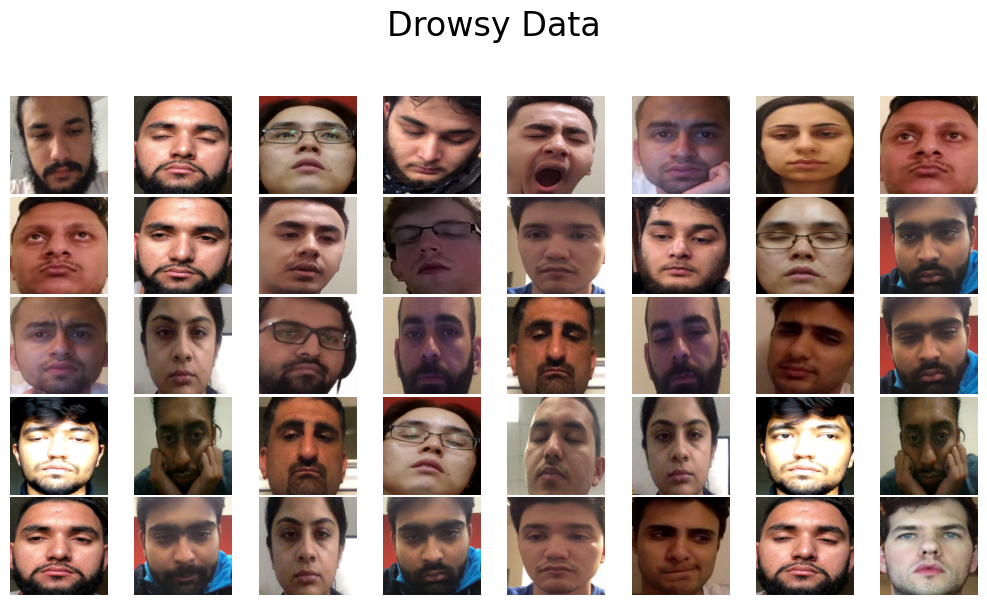

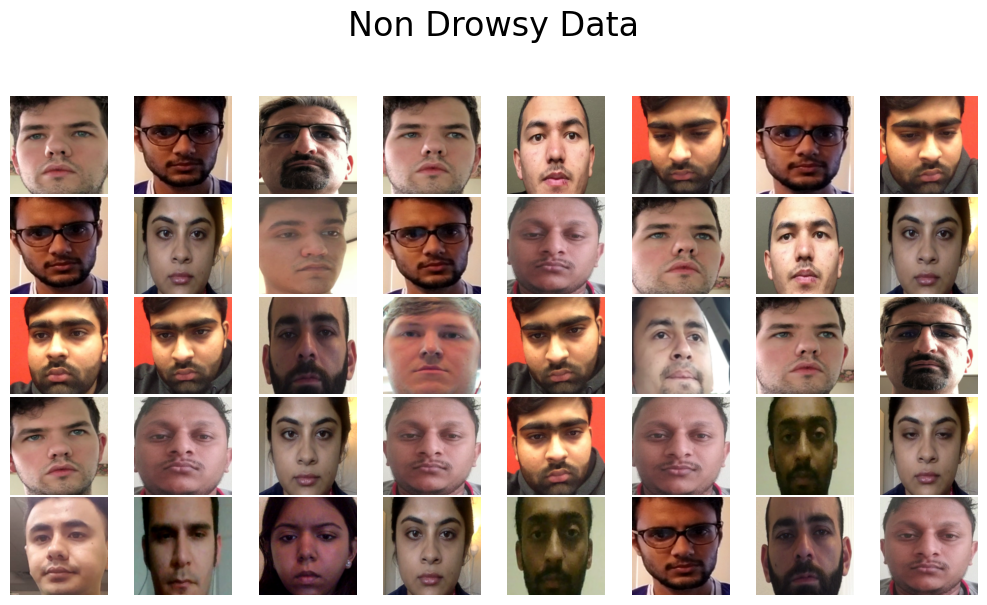

In [5]:
# looking at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(drowsy_images, 'Drowsy Data')
plot_images(nondrowsy_images, 'Non Drowsy Data')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [6]:
# normalize to interval of [0,1]
drowsy_images = np.array(drowsy_images) / 255
nondrowsy_images = np.array(nondrowsy_images) / 255

### **Train Test Split**

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
drowsy_x_train, drowsy_x_test, drowsy_y_train, drowsy_y_test = train_test_split(
    drowsy_images, drowsy_labels, test_size=0.2)
nondrowsy_x_train, nondrowsy_x_test, nondrowsy_y_train, nondrowsy_y_test = train_test_split(
    nondrowsy_images, nondrowsy_labels, test_size=0.2)


X_train = np.concatenate((nondrowsy_x_train, drowsy_x_train), axis=0)
X_test = np.concatenate((nondrowsy_x_test, drowsy_x_test), axis=0)
y_train = np.concatenate((nondrowsy_y_train, drowsy_y_train), axis=0)
y_test = np.concatenate((nondrowsy_y_test, drowsy_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

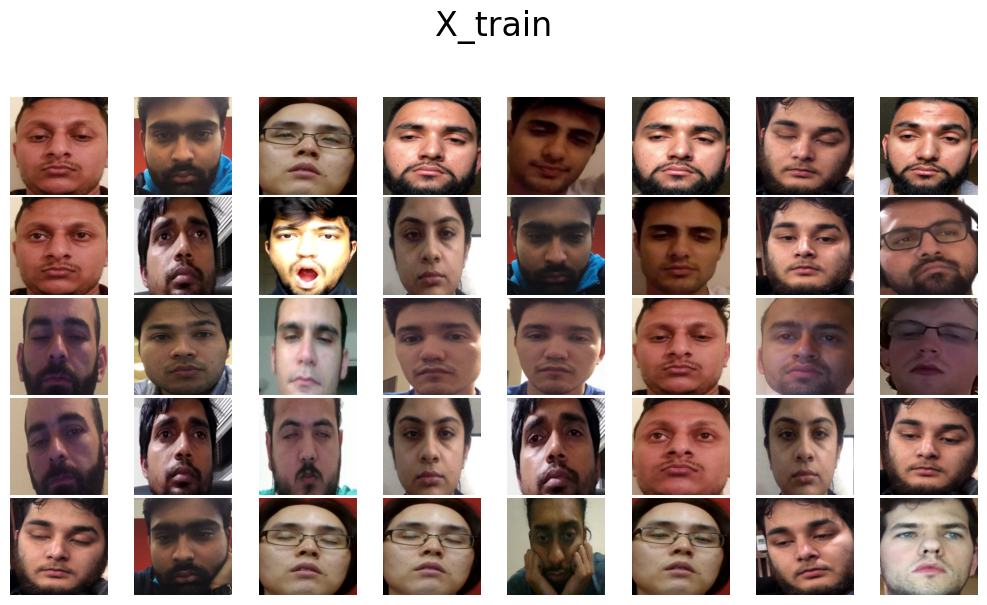

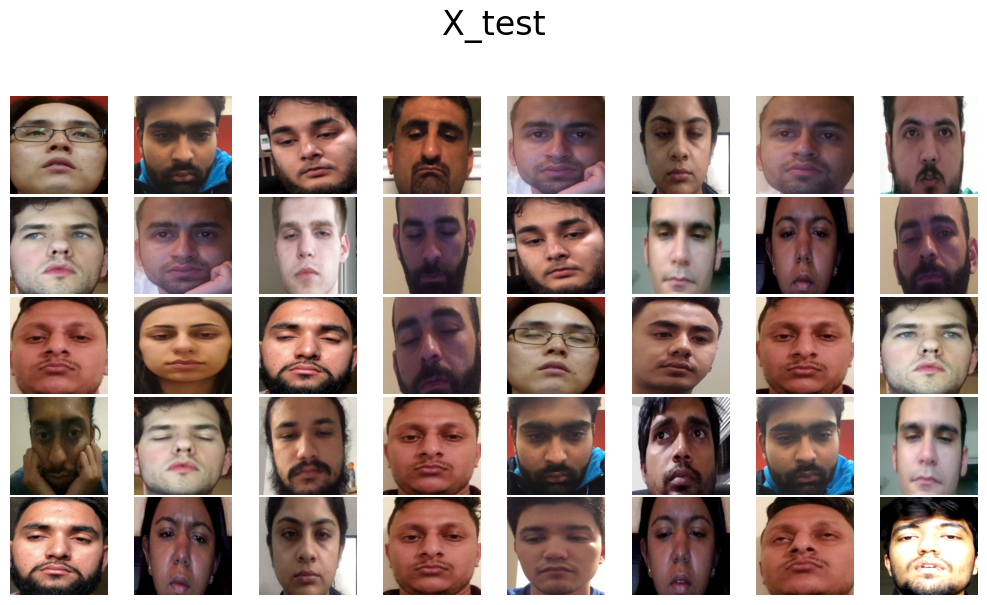

In [8]:
plot_images(drowsy_x_train, 'X_train')
plot_images(drowsy_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing drowsy and Nondrowsy for X_train and X_test

## **Building and Visualizing model**

# Training **Resnet 50**

In [9]:
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=outputs)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

94765736/94765736 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=100)

Epoch 1/100
250/250 [==============================] - 93s 327ms/step - loss: 1.3906 - accuracy: 0.5561 - val_loss: 0.6800 - val_accuracy: 0.6605
Epoch 2/100
250/250 [==============================] - 79s 314ms/step - loss: 1.0483 - accuracy: 0.5704 - val_loss: 0.7847 - val_accuracy: 0.5800
Epoch 3/100
250/250 [==============================] - 78s 314ms/step - loss: 1.0587 - accuracy: 0.5867 - val_loss: 0.5487 - val_accuracy: 0.7060
Epoch 4/100
250/250 [==============================] - 78s 311ms/step - loss: 1.0560 - accuracy: 0.5854 - val_loss: 0.6678 - val_accuracy: 0.6335
Epoch 5/100
250/250 [==============================] - 78s 313ms/step - loss: 0.9850 - accuracy: 0.6036 - val_loss: 0.4768 - val_accuracy: 0.7490
Epoch 6/100
250/250 [==============================] - 79s 314ms/step - loss: 1.0206 - accuracy: 0.6097 - val_loss: 0.5906 - val_accuracy: 0.7150
Epoch 7/100
250/250 [==============================] - 79s 316ms/step - loss: 1.2016 - accuracy: 0.6026 - val_loss: 0.5229 -

In [12]:
model.save('resnet_drowsiness.h5')

In [13]:
model.save_weights('resnetweights_drowsiness.hdf5')

In [65]:
model = load_model('resnet_drowsiness.h5')

## **Evaluating Model**

In [66]:
y_pred = model.predict(X_test, batch_size=batch_size)

63/63 [==============================] - 2s 16ms/step


### Visulaizing First 10 predictions

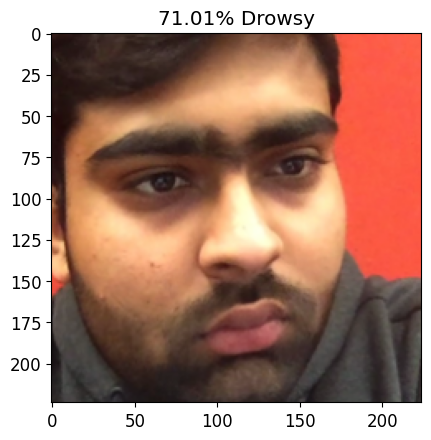

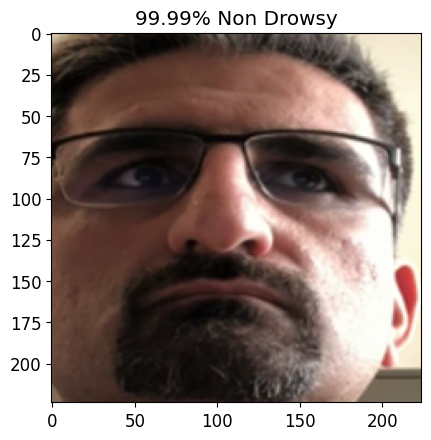

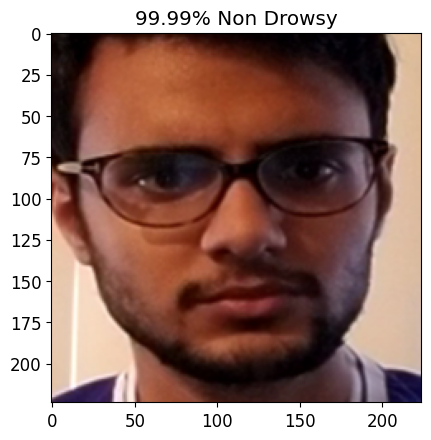

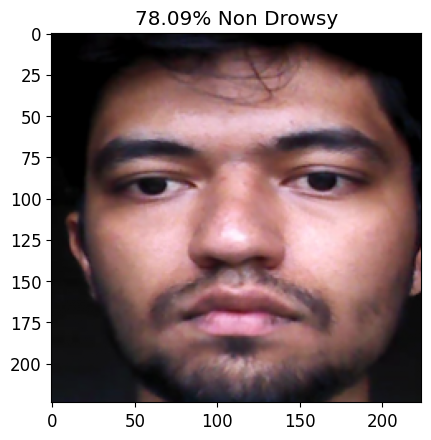

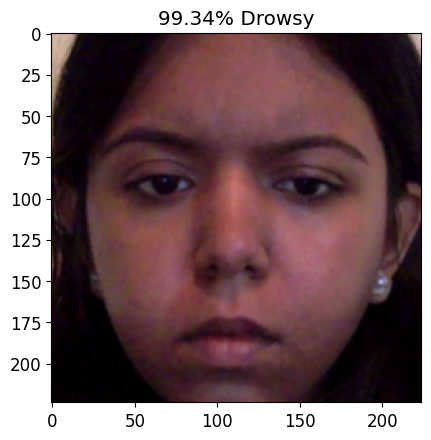

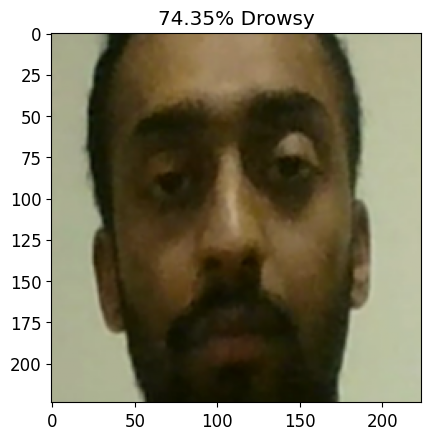

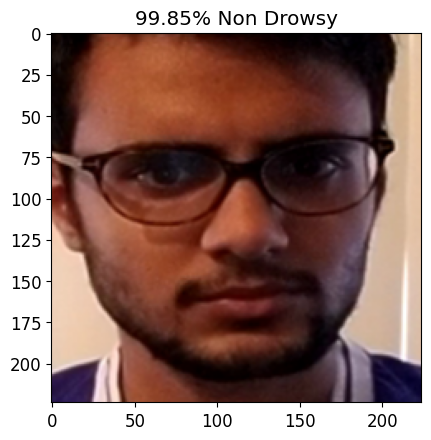

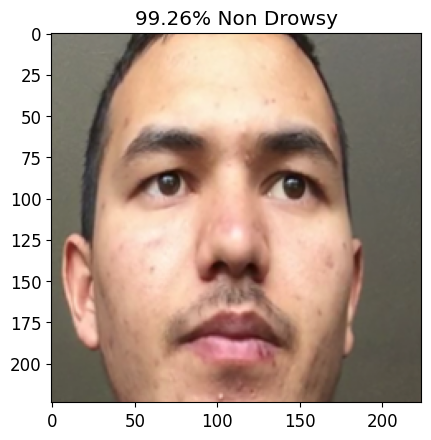

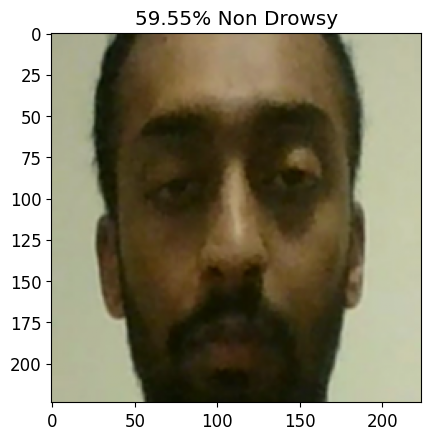

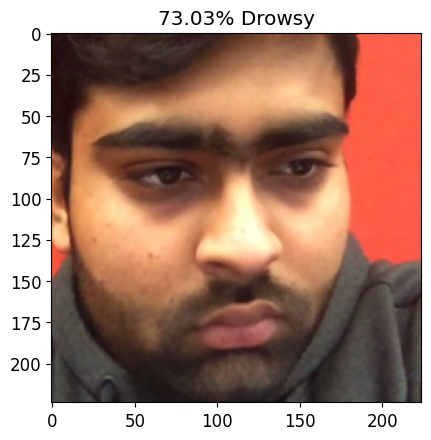

In [67]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% Drowsy')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% Non Drowsy')
  plt.imshow(X_test[index])
  plt.show()

In [68]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

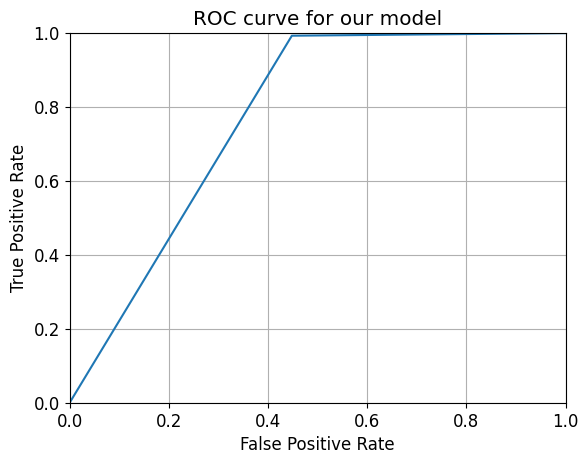

In [69]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


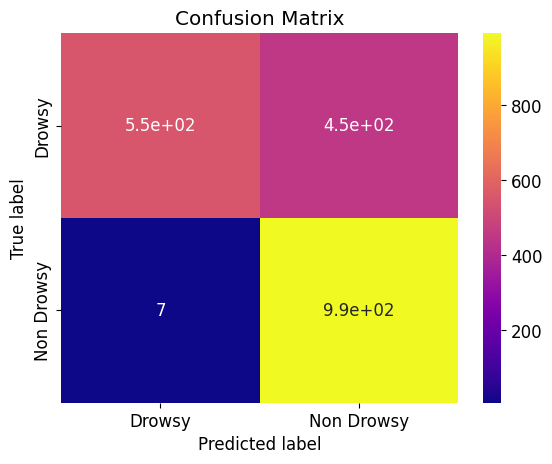

Confusion Matrix with Normalized Values


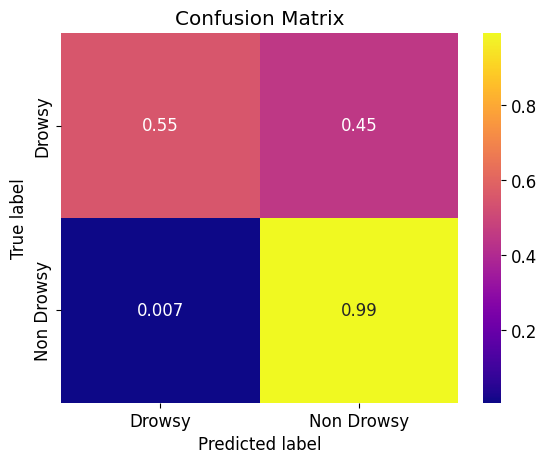

In [70]:
def plot_confusion_matrix(normalize):
  classes = ['Drowsy','Non Drowsy']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.99      0.55      0.71      1000
           1       0.69      0.99      0.81      1000

    accuracy                           0.77      2000
   macro avg       0.84      0.77      0.76      2000
weighted avg       0.84      0.77      0.76      2000



### **Accuracy and Loss Plots**

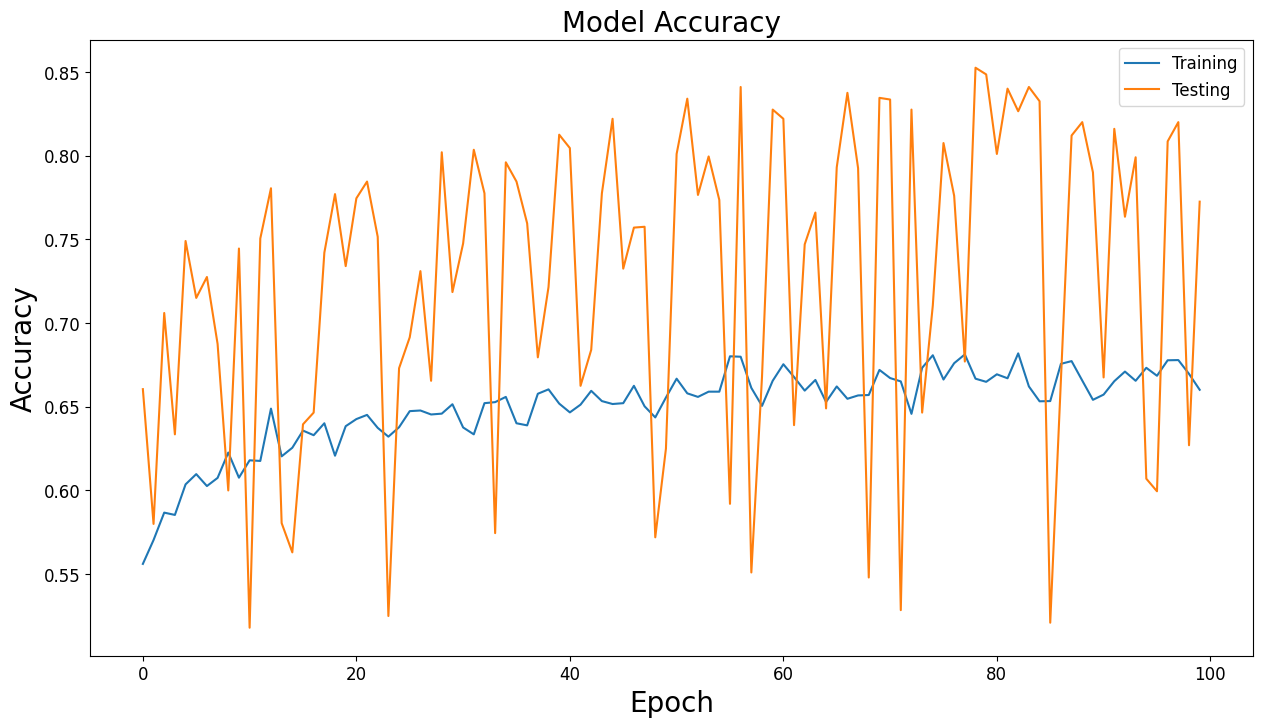

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.xlabel('Epoch',fontsize=20)

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_accuracy.png')
plt.show()


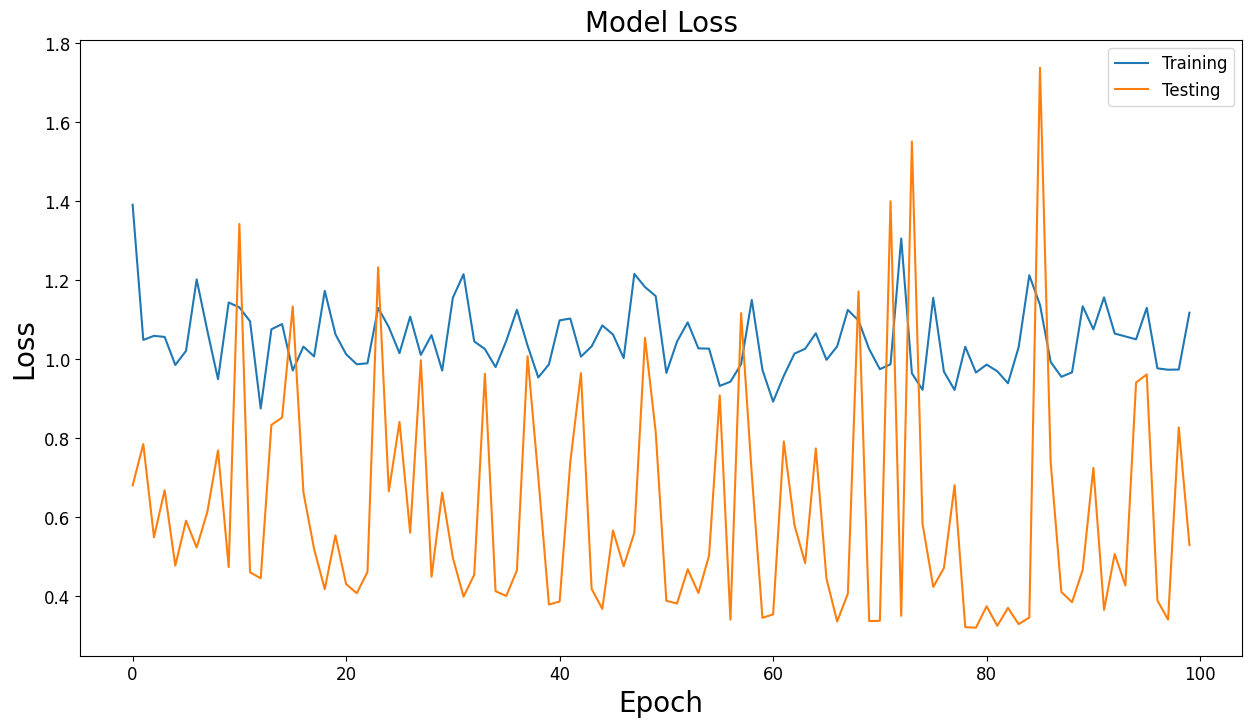

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epoch',fontsize=20)

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_loss.png')
plt.show()

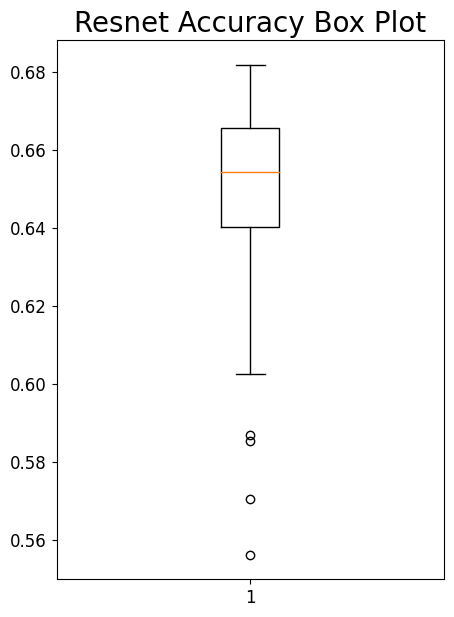

In [ ]:
plt.figure(figsize=(5,7))
plt.boxplot(history.history['accuracy'])
plt.title("Resnet Accuracy Box Plot",fontsize=20)
plt.show()

# Training **Mobile Net**

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten , Conv1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,MaxPooling1D
from tensorflow.keras.utils import plot_model
def model_b():
    new_input = Input(shape=(X_train.shape[1],X_train.shape[2], 3))
    i1 = tf.keras.applications.MobileNet(include_top=False,weights="imagenet",input_tensor=new_input,
                        input_shape=None,
                         pooling=None,
                    )(new_input)
    i1 = tf.keras.layers.Flatten()(i1)
    class1 = Dense(1024, activation='relu')(i1)
    class1 = Dense(256, activation='relu')(class1)
    class1 = Dense(128, activation='relu')(class1)
    class1 = Dense(64, activation='relu')(class1)
    output = Dense(2, activation='sigmoid')(class1)
    model = Model(inputs=new_input, outputs=output)
    return model
md = model_b()
md.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_11 (Dense)            (None, 1024)              51381248  
                                                                 
 dense_12 (Dense)            (None, 256)               262400    
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                           

In [47]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

METRICS = [
    'accuracy',
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.Precision(name='precision')
]

model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=METRICS
)

# Define early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    verbose=1,
    shuffle=True,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


Epoch 1/100
250/250 [==============================] - 26s 41ms/step - loss: 0.0135 - accuracy: 0.9980 - recall: 0.9995 - precision: 0.6655 - val_loss: 0.0754 - val_accuracy: 0.9595 - val_recall: 1.0000 - val_precision: 0.6431
Epoch 2/100
250/250 [==============================] - 8s 33ms/step - loss: 0.0102 - accuracy: 0.9980 - recall: 0.9998 - precision: 0.6909 - val_loss: 5.3165e-05 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 0.6676
Epoch 3/100
250/250 [==============================] - 8s 32ms/step - loss: 1.9161e-04 - accuracy: 0.9999 - recall: 0.9999 - precision: 0.6707 - val_loss: 7.2512e-06 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 0.6696
Epoch 4/100
250/250 [==============================] - 8s 33ms/step - loss: 0.0148 - accuracy: 0.9983 - recall: 0.9994 - precision: 0.6998 - val_loss: 0.0053 - val_accuracy: 0.9995 - val_recall: 1.0000 - val_precision: 0.6664
Epoch 5/100
250/250 [==============================] - 8s 32ms/step - loss: 0.0433 

In [ ]:
model.save('mobilenet.h5')

In [ ]:
model.save_weights('mobilenet.hdf5')

In [ ]:
model = load_model('mobilenet.h5')

## **Evaluating Model**

In [48]:
y_pred = model.predict(X_test, batch_size=batch_size)

63/63 [==============================] - 1s 10ms/step


### Visulaizing First 10 predictions

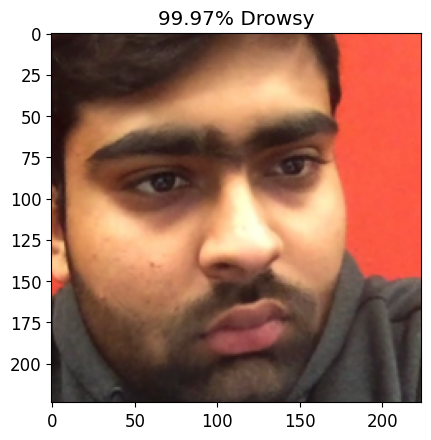

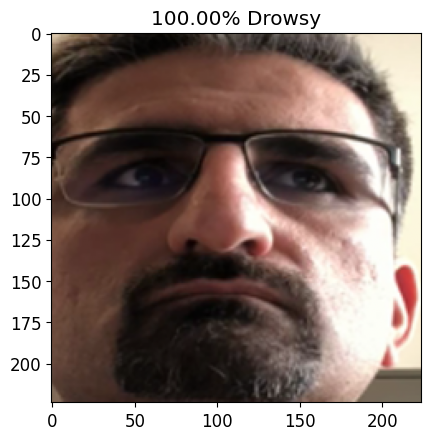

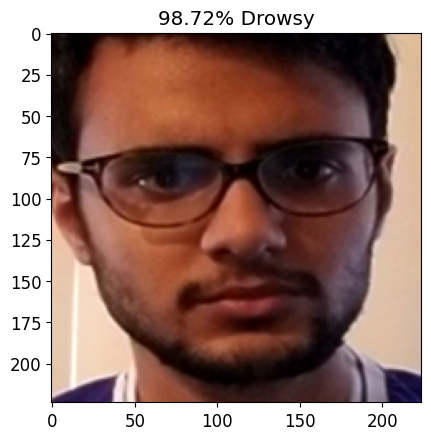

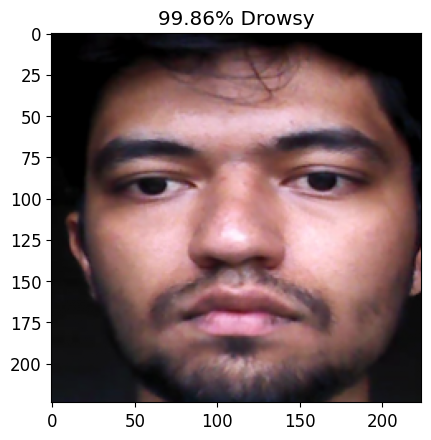

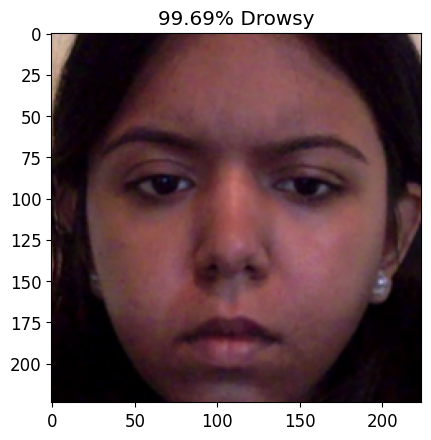

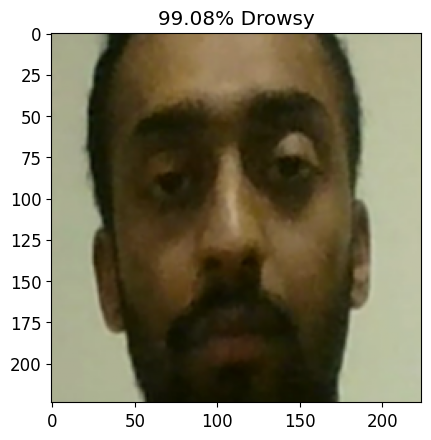

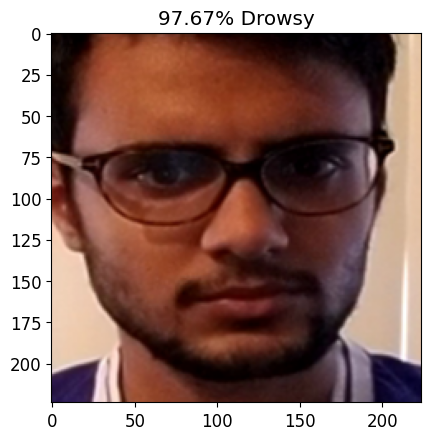

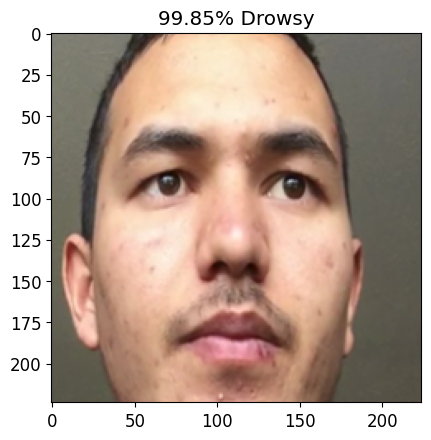

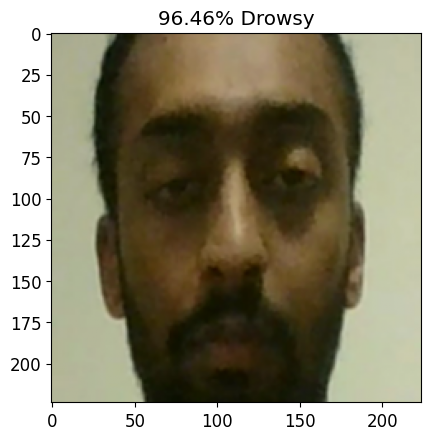

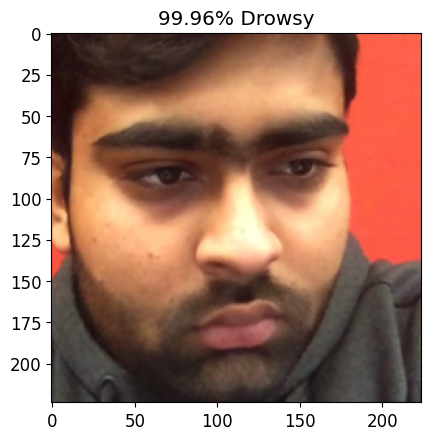

In [49]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% Drowsy')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% Non Drowsy')
  plt.imshow(X_test[index])
  plt.show()

In [50]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

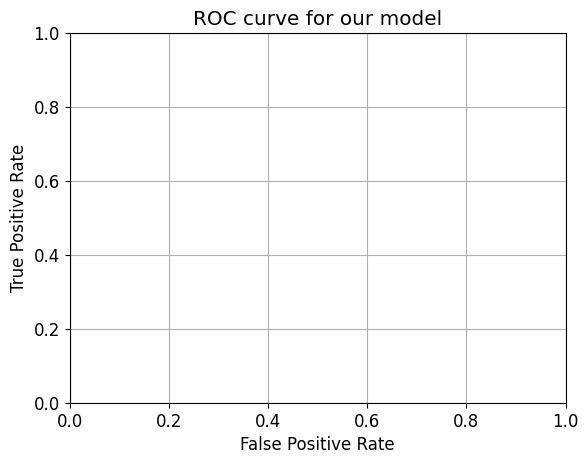

In [51]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


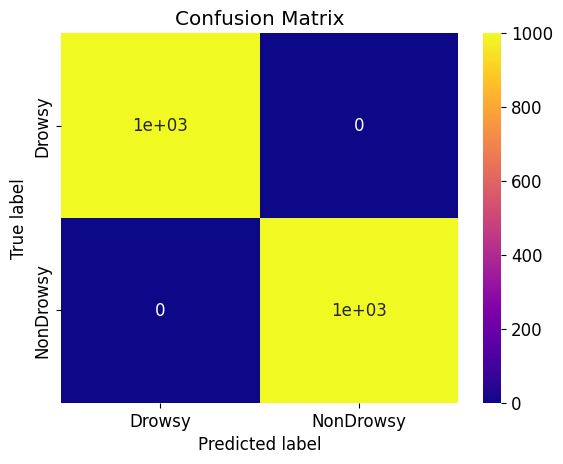

Confusion Matrix with Normalized Values


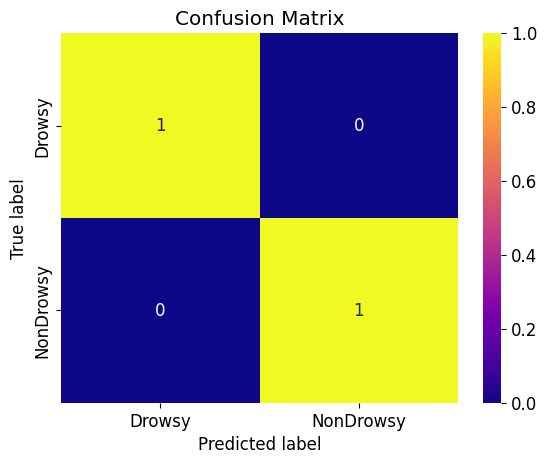

In [52]:
def plot_confusion_matrix(normalize):
  classes = ['Drowsy','NonDrowsy']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



### **Accuracy and Loss Plots**

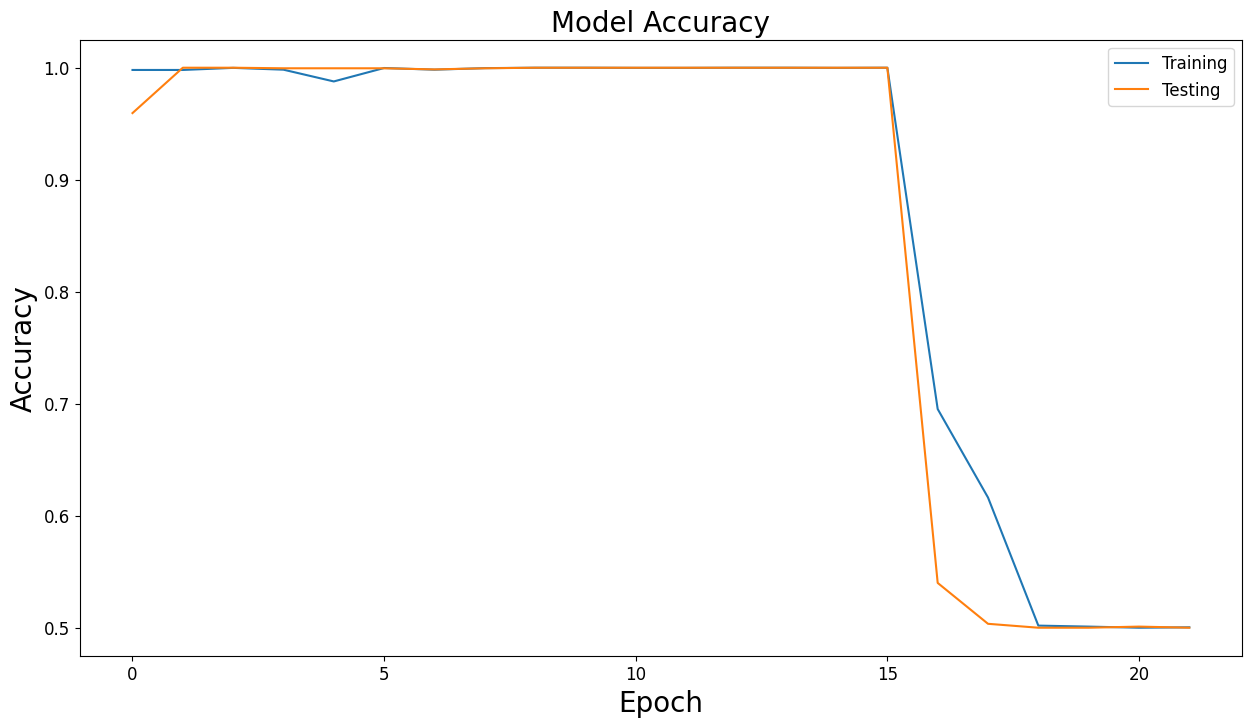

In [54]:
plt.figure(figsize=(15,8))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.xlabel('Epoch',fontsize=20)

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_accuracy.png')
plt.show()


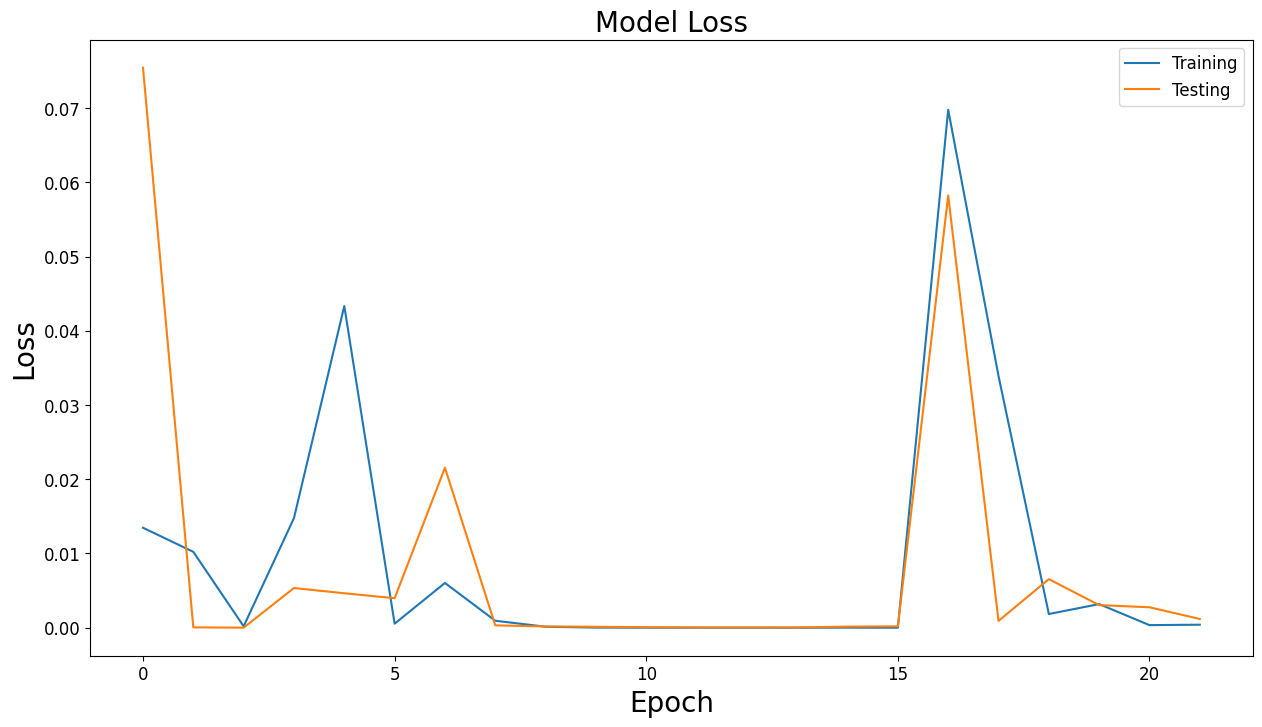

In [55]:
plt.figure(figsize=(15,8))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epoch',fontsize=20)

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_loss.png')
plt.show()

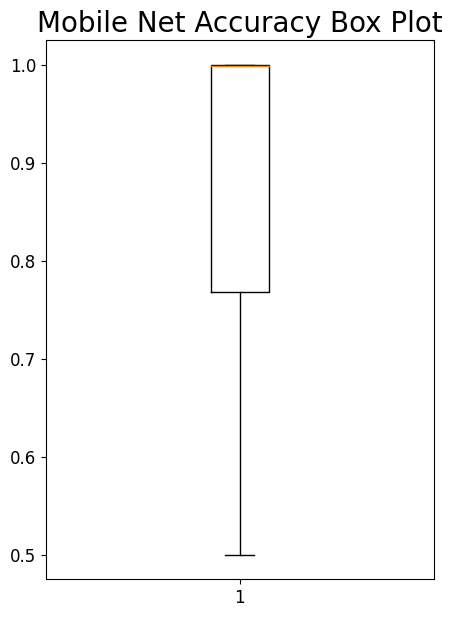

In [57]:
plt.figure(figsize=(5,7))
plt.boxplot(history.history['accuracy'])
plt.title("Mobile Net Accuracy Box Plot",fontsize=20)
plt.show()